In [1]:
%load_ext autoreload
%autoreload 2
import sys

from matplotlib import rc

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_svmlight_file
import numpy as np
import pickle
import glob
import os

from matplotlib.ticker import MaxNLocator

from utils import unpickle_dir

from constants import LOSS_PER_EPOCH

LOG_SCALE = True

In [2]:
optimums = unpickle_dir('dump/optimum-epsilon/')
exact_optimum = optimums['baselines']['epsilon']

In [3]:
n, d = 400000, 2000

In [4]:
def plot_scores(data, label, shift=1, color=None, display_name=None, marker=None, markevery=None):
    scores = []
    for i in range(0, len(data['results'])):
        scores += [np.copy(data['results'][i][1])]
    scores = np.array(scores)
    scores[scores == 0] = 1e20
    scores[np.isinf(scores)] = 1e20
    scores[np.isnan(scores)] = 1e20
    plt.plot(np.arange(scores.shape[1] - shift) / LOSS_PER_EPOCH,
             np.mean(scores[:, :-shift], axis=0) - exact_optimum, label=display_name, color=color,
             marker=marker, markevery=markevery)
    scores[scores > 1e10] = np.inf
    plt.fill_between(np.arange(scores.shape[1] - shift) / LOSS_PER_EPOCH,
                     np.mean(scores[:, :-shift], axis=0) - np.std(scores[:, :-shift], axis=0) - exact_optimum,
                     np.mean(scores[:, :-shift], axis=0) + np.std(scores[:, :-shift], axis=0) - exact_optimum,
                     alpha=0.2, color=color)
def plot_final(method, quantization, split_way, num_nodes, label, display_name, color, marker, markevery):
#     print(method, quantization, split_way)
    data = unpickle_dir('dump/epsilon-final-' + method + "-" + quantization + ("" if len(quantization) == 0 else "-")
                    + split_way + "-" + str(num_nodes))
    plot_scores(data, label, color=color, display_name=display_name, marker=marker, markevery=markevery)

def plot_scores_vs_bits(data, label, quantization, num_nodes, shift=1, display_name=None,
                        color=None, marker=None, markevery=None):
    scores = []
    for i in range(0, len(data['results'])):
        scores += [np.copy(data['results'][i][1])]
    scores = np.array(scores)
    scores[scores == 0] = 1e20
    scores[np.isinf(scores)] = 1e20
    scores[np.isnan(scores)] = 1e20
    if quantization == "random-20":
        num_bits_array = n / LOSS_PER_EPOCH * np.arange(scores.shape[1] - shift) * 64 * (2 ) * 20+ 1#1e+8
    elif quantization == "top-20":
        num_bits_array = n / LOSS_PER_EPOCH * np.arange(scores.shape[1] - shift) * (64 + 11) * (2 ) * 20+ 1#1e+8
    elif quantization == "":
        num_bits_array = n / LOSS_PER_EPOCH * np.arange(scores.shape[1] - shift) * 64 * (2) * d +1#1e+8
    elif quantization == "qsgd-4bit":
        num_bits_array = n / LOSS_PER_EPOCH * np.arange(scores.shape[1] - shift) * (4 + 1) * (2 ) * d + 1#1e+8
        
    plt.plot(num_bits_array,
             np.mean(scores[:, :-shift], axis=0) - exact_optimum, label=display_name,
             color=color, marker=marker, markevery=markevery)
    scores[scores > 1e10] = np.inf
    plt.fill_between(num_bits_array,
                     np.mean(scores[:, :-shift], axis=0) - exact_optimum - np.std(scores[:, :-shift], axis=0),
                     np.mean(scores[:, :-shift], axis=0) - exact_optimum + np.std(scores[:, :-shift], axis=0),
                     alpha=0.2, color=color)


def plot_final_vs_bits(method, quantization, split_way, num_nodes, label, display_name, color, marker, markevery):
    data = unpickle_dir('dump/epsilon-final-' + method + "-" + quantization + ("" if len(quantization) == 0 else "-")
                    + split_way + "-" + str(num_nodes))
    plot_scores_vs_bits(data, label, quantization, num_nodes, display_name=display_name,
                        color=color, marker=marker, markevery=markevery)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


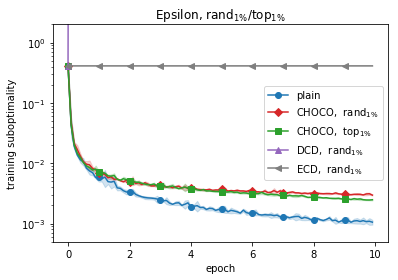

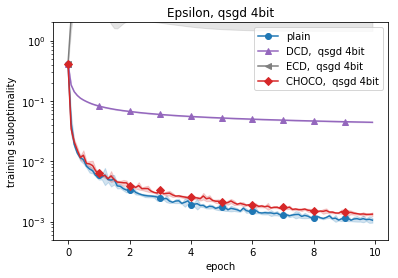

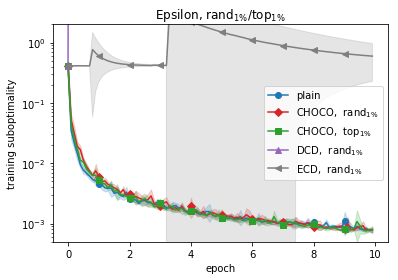

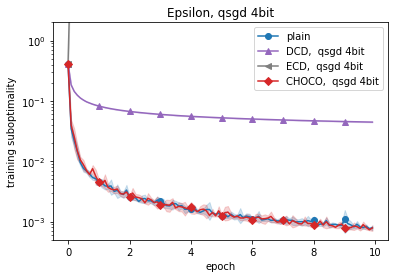

In [5]:
num_nodes = 9
for split_way in ["sorted", 'random']:
    plt.figure()
    fig = plt.gcf()
    for method, quantization, display_name, color, marker, markevery in [
                                 ("decentralized", "", "plain", "C0", "o", 10), #("centralized", ""),
                                 ("choco", "random-20", "CHOCO,  $\operatorname{rand}_{1\%}$", "C3", "D", 10),
                                 ("choco", "top-20", "CHOCO,  top$_{1\%}$", "C2", "s", 10),
                                 ("dcd", "random-20", "DCD,  $\operatorname{rand}_{1\%}$", "C4", "^", 10),
                                 ("ecd", "random-20", "ECD,  $\operatorname{rand}_{1\%}$", "C7", "<", 10),
                                ]:
        plot_final(method, quantization, split_way, num_nodes, method + " " + quantization,
                   display_name=display_name, color=color, marker=marker, markevery=markevery)
    plt.title("Epsilon, rand$_{1\%}$/top$_{1\%}$")
    plt.xlabel("epoch")
    plt.ylabel("training suboptimality")
    if LOG_SCALE:
        plt.yscale("log")
    plt.ylim(5e-4, 2)
    plt.legend()
    plt.show()


    plt.figure()
    fig = plt.gcf()
    for method, quantization, display_name, color, marker, markevery in [
                                 ("decentralized", "", "plain", "C0", "o", 10),
    #                              ("centralized", ""),
                                 ("dcd", "qsgd-4bit", "DCD,  qsgd 4bit", "C4", "^", 10),
                                 ("ecd", "qsgd-4bit", "ECD,  qsgd 4bit", "C7", "<", 10),
                                 ("choco", "qsgd-4bit", "CHOCO,  qsgd 4bit", "C3", "D", 10),
                                 #("ecd", "qsgd-16bit")
                                ]:
        plot_final(method, quantization, split_way, num_nodes, method + " " + quantization,
                   display_name=display_name, color=color, marker=marker, markevery=markevery)
    plt.title("Epsilon, qsgd 4bit")
    plt.xlabel("epoch")
    plt.ylabel("training suboptimality")
    if LOG_SCALE:
        plt.yscale("log")
    plt.ylim(5e-4, 2)
    plt.legend()
    plt.show()

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


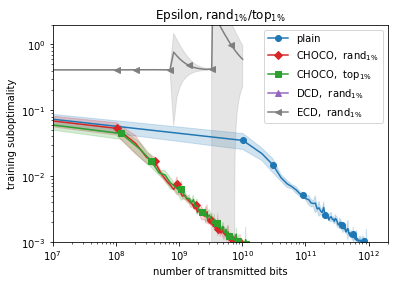

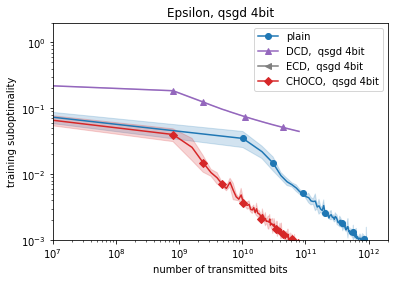

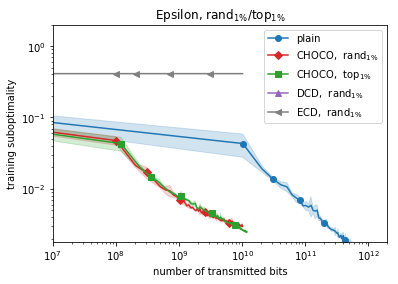

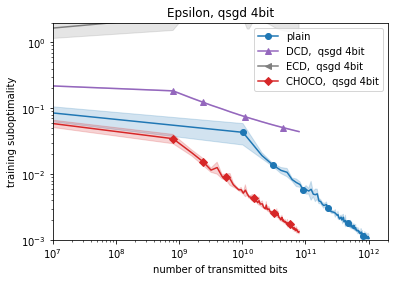

In [6]:
num_nodes = 9
for split_way in ["random", "sorted"]:
    plt.figure()
    fig = plt.gcf()
    for method, quantization, display_name, color, marker, markevery in [
                                 ("decentralized", "", "plain", "C0", "o", 0.1), #("centralized", ""),
                                 ("choco", "random-20", "CHOCO,  $\operatorname{rand}_{1\%}$", "C3", "D", 0.1),
                                 ("choco", "top-20", "CHOCO,  top$_{1\%}$", "C2", "s", 0.1),
                                 ("dcd", "random-20", "DCD,  $\operatorname{rand}_{1\%}$", "C4", "^", 0.1),
                                 ("ecd", "random-20", "ECD,  $\operatorname{rand}_{1\%}$", "C7", "<", 0.1),
                                ]:
        plot_final_vs_bits(method, quantization, split_way, num_nodes, method + " " + quantization,
                           display_name=display_name, color=color, marker=marker, markevery=markevery)
    plt.title("Epsilon, rand$_{1\%}$/top$_{1\%}$")
    plt.xlabel("number of transmitted bits")
    plt.ylabel("training suboptimality")
    if LOG_SCALE:
        plt.yscale("log")
        plt.xscale("log")
    plt.ylim(1e-3, 2)
    if split_way == "sorted":
        plt.ylim(1.8e-3, 2)
    plt.xlim(1e7, 2e12)
    plt.legend(loc=1)
    plt.show()


    plt.figure()
    fig = plt.gcf()
    for method, quantization, display_name, color, marker, markevery in [
                                 ("decentralized", "", "plain", "C0", "o", 0.1),
    #                              ("centralized", ""),
                                 ("dcd", "qsgd-4bit", "DCD,  qsgd 4bit", "C4", "^", 0.1),
                                 ("ecd", "qsgd-4bit", "ECD,  qsgd 4bit", "C7", "<", 0.1),
                                 ("choco", "qsgd-4bit", "CHOCO,  qsgd 4bit", "C3", "D", 0.1),
                                 #("ecd", "qsgd-16bit")
                                ]:
        plot_final_vs_bits(method, quantization, split_way, num_nodes, method + " " + quantization,
                           display_name, color, marker=marker, markevery=markevery)
    plt.title("Epsilon, qsgd 4bit")
    plt.xlabel("number of transmitted bits")
    plt.ylabel("training suboptimality")
    plt.ylim(1e-3, 2)
    if LOG_SCALE:
        plt.yscale("log")
        plt.xscale("log")
    plt.legend(loc=1)
    plt.xlim(1e7, 2e12)
    plt.show()